In [1]:
import copy
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

from sample_players import *
from isolation import Board
from game_agent import CustomPlayer
from game_agent import custom_score, weighted_improved_score, blanks_score
from tournament import *

%matplotlib inline

In [2]:
TIME_LIMIT = 150

def runTrial(game, numTrials=1000):
    wins = 0
    avg_depth = 0

    for i in range(numTrials):
        new_game = game.copy()
        try:
            winner, history, outcome = new_game.play(time_limit=TIME_LIMIT)
            if winner == game.__player_1__:
                wins += 1
            avg_depth += len(history)
        except ValueError:
            return -1, -1

    return wins/numTrials, avg_depth/numTrials

def poolRunTrial(inputs):
    game, n_trials = inputs
    return runTrial(game, n_trials)
    
def calcOpeningMovePerf(width, 
                        height, 
                        player1, 
                        player2,
                        numTrials,
                        perspective='player1',
                        use_pool=True):
    # Create arrays to store results of game outcomes and depth
    probs = np.zeros((width,height))-1
    dpths = np.zeros_like(probs)

    # Create tuples of input to process with Pool
    gameStarts = []

    for i in range(round(height/2)):
        for j in range(0,i+1):
            p1 = copy.deepcopy(player1)
            p2 = copy.deepcopy(player2)
            if perspective == 'player1':
                p2.first_move = None
            else:
                p2.first_move = (i,j)
                
            game = Board(p1, p2, width, height)
            gameStarts.append((game.copy(), numTrials))

    if use_pool:
        # Create Pool and run games
        with Pool() as p:
            results = p.map(poolRunTrial, gameStarts)
    else:
        # Run sequentially
        results = [poolRunTrial(gameStart) for gameStart in gameStarts]

    # Fill in results
    i_results = 0

    for i in range(round(height/2)):
        for j in range(0,i+1):
            prob, depth = results[i_results]
            # Reflect along diagonal
            moves = [(i,j), (j,i)]
            for move in moves:
                probs[move[0],move[1]] = prob
                dpths[move[0],move[1]] = depth

            i_results += 1

    # Reflect about vertical axis
    for i in range(round(height/2)):
        for j in range(round(width/2),width):
            probs[i,j] = probs[i,width-j-1]
            dpths[i,j] = dpths[i,width-j-1]

    # Reflect about horizontal axis
    for i in range(round(height/2), height):
        for j in range(width):
            probs[i,j] = probs[height-i-1,j]
            dpths[i,j] = dpths[height-i-1,j]
            
    return probs, dpths

### Performance Against a Random Player

In [3]:
# Define game size and player types
w = 7
h = 7
CUSTOM_ARGS = {"method": 'alphabeta', 'iterative': True}
player1 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)
player2 = RandomPlayer()

# Define number of trials per opening move
numTrials = 2000

#### As Player 1

In [4]:
probs, dpths = calcOpeningMovePerf(w, h, player1, player2, numTrials)

probs.tofile('probs_against_random_as_p1.np')
dpths.tofile('dpths_against_random_as_p1.np')

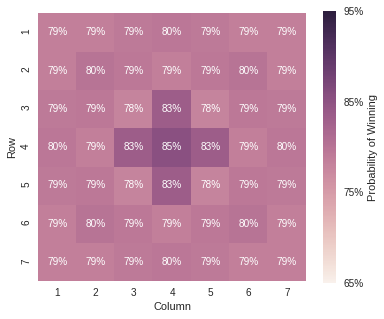

In [5]:
vmin = 0.65
vmax = 0.95

plt.figure(figsize=(6,5))
#plt.title("Result of Game Based on Opening Move")
g = sns.heatmap(probs, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1), 
                fmt='.0%',
                vmin=vmin,
                vmax=vmax)
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
ticks = np.linspace(vmin,vmax,(vmax-vmin)/0.05-1)
cbar.set_ticks(ticks)
cbar.set_ticklabels(["{:2.0f}%".format(100*tick) for tick in ticks])
cbar.set_label('Probability of Winning')
plt.savefig('Outcomes_Against_Random_as_p1.png', dpi=240)

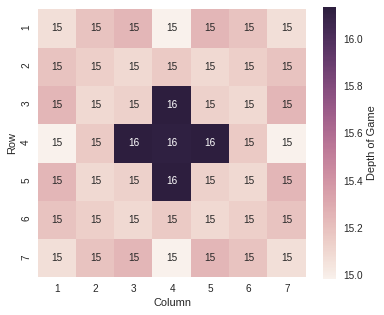

In [6]:
vmin = 0.65
vmax = 0.95

plt.figure(figsize=(6,5))
#plt.title("Depth of Game Based on Opening Move")
g = sns.heatmap(dpths, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1))
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
cbar.set_label('Depth of Game')
plt.savefig('Depths_Against_Random_as_p1.png', dpi=240)

#### As Player 2

In [ ]:
probs, dpths = calcOpeningMovePerf(w, h, player2, player1, numTrials)
probs = 1 - probs

probs.tofile('probs_against_random_as_p2.np')
dpths.tofile('dpths_against_random_as_p2.np')

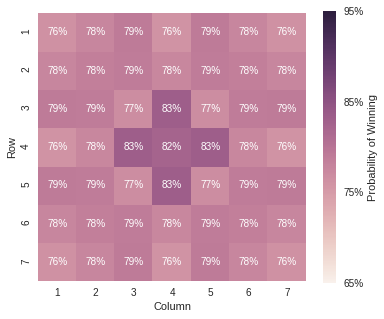

In [8]:
vmin = 0.65
vmax = 0.95

plt.figure(figsize=(6,5))
#plt.title("Result of Game Based on Opening Move")
g = sns.heatmap(probs, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1), 
                fmt='.0%',
                vmin=vmin,
                vmax=vmax)
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
ticks = np.linspace(vmin,vmax,(vmax-vmin)/0.05-1)
cbar.set_ticks(ticks)
cbar.set_ticklabels(["{:2.0f}%".format(100*tick) for tick in ticks])
cbar.set_label('Probability of Winning')
plt.savefig('Outcomes_Against_Random_as_p2.png', dpi=240)

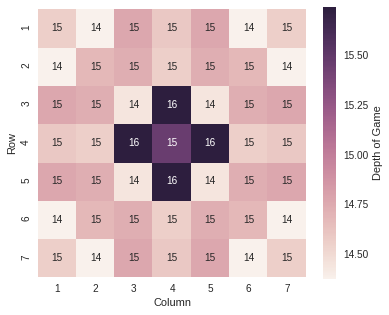

In [9]:
plt.figure(figsize=(6,5))
#plt.title("Depth of Game Based on Opening Move")
g = sns.heatmap(dpths, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1))
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
cbar.set_label('Depth of Game')
plt.savefig('Depths_Against_Random_as_p2.png', dpi=240)

### Enumerate Unique Moves

In [159]:
def check_for_symmetry(move, unique_moves, width=7, height=7):
    '''
    Checks if the move is a rotation or reflection of another move
    '''
    # Check if move is in unique moves
    if str(move) in unique_moves:
        return str(move)
    
    # Check rotating the board finds a symmetric move
    x_shift = round(width/2)-1
    y_shift = round(height/2)-1
    x_trans = y_shift+x_shift
    y_trans = -x_shift+y_shift
    
    rot_move = copy.deepcopy(move)
    for i in range(3):
        rot_move = [(-m[1]+x_trans,m[0]+y_trans) for m in rot_move]
        if str(rot_move) in unique_moves:
            unique_moves[str(rot_move)].append(move)
            return rot_move
        
    # Check for reflection
    ref_move = [(m[0],-(m[1]-y_shift)+y_shift) for m in move]
    if str(ref_move) in unique_moves:
        unique_moves[str(ref_move)].append(move)
        return ref_move
    
    ref_move = [(-(m[0]-x_shift)+x_shift,m[1]) for m in move]
    if str(ref_move) in unique_moves:
        unique_moves[str(ref_move)].append(move)
        return ref_move
    
    ref_move = [(m[1]-y_shift+x_shift,m[0]-x_shift+y_shift) for m in move]
    if str(ref_move) in unique_moves:
        unique_moves[str(ref_move)].append(move)
        return ref_move
    
    ref_move = [(-(m[1]-y_shift)+x_shift, -(m[0]-x_shift)+y_shift) for m in move]
    if str(ref_move) in unique_moves:
        unique_moves[str(ref_move)].append(move)
        return ref_move
            
    unique_moves[str(move)] = []
    
    return move

In [160]:
move = [(3,3), (4,1)]
foo = {}
print (check_for_symmetry(move,foo))

[(3, 3), (4, 1)]


In [161]:
# Define game size and player types
w = 7
h = 7
CUSTOM_ARGS = {"method": 'alphabeta', 'iterative': True, 'timeout':10}
player1 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)
player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)

game = Board(player1, player2, w, h)

In [233]:
def search_moves(move_history, game, unique_moves, depth):
    hist = ast.literal_eval(move_history)
    new_game = game.forecast_move(hist[0])
    for move in hist[1:]:
        new_game = new_game.forecast_move(move)
    
    legal_moves = new_game.get_legal_moves()
    for move in legal_moves:
        new_hist = ast.literal_eval(move_history)
        new_hist.append(move)
        unique_move = check_for_symmetry(new_hist, unique_moves)
        
        if new_hist == unique_move and depth > 0:
            search_moves(str(new_hist), game, unique_moves, depth-1)

In [235]:
# Determine inital moves
moves = {0:game.get_legal_moves()}
unique = {}
for move in moves[0]:
    check_for_symmetry([move], unique)
    
# Search initial moves
first_moves = list(unique.keys())
for move in first_moves:
    search_moves(move, game, unique, 2)

In [254]:
move_data = pd.DataFrame()
moves = list(unique.keys())
lens = [len(unique[key]) for key in moves]
move_data['Move'] = moves
move_data['Duplicates'] = lens
move_data.sort_values('Duplicates', inplace=True, ascending=False)

In [259]:
move_data.head(10)

,Move,Duplicates
8175,"[(3, 3), (2, 1)]",7
8061,"[(3, 3), (1, 0)]",7
2,"[(2, 0)]",7
1,"[(1, 0)]",7
5,"[(2, 1)]",7
8094,"[(3, 3), (2, 0)]",7
8282,"[(3, 3), (3, 2)]",3
8154,"[(3, 3), (1, 1)]",3
8246,"[(3, 3), (2, 2)]",3
8049,"[(3, 3), (0, 0)]",3


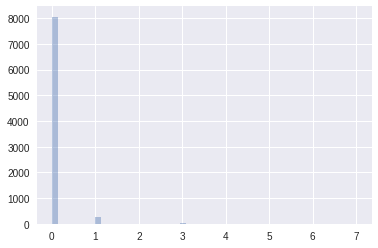

In [256]:
sns.distplot(lens, kde=False)

### Against Improved Score Player

In [4]:
# Define game size and player types
w = 7
h = 7
CUSTOM_ARGS = {"method": 'alphabeta', 'iterative': True, 'timeout':30}
player1 = CustomPlayer(score_fn=custom_score, **CUSTOM_ARGS)
player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)

# Define number of matches
numMatches = 50

#### As Player 1

In [20]:
results = {
    'player1':[],
    'player2':[]
}

player1 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)
player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)

# Define number of matches
numMatches = 50

# Play
for match in range(numMatches):
    result = play_match(player1, player2)
    results['player1'].append(result[0])
    results['player2'].append(result[1])
    
baseline_results = copy.deepcopy(results)

In [14]:
results = {
    'player1':[],
    'player2':[]
}

player1 = CustomPlayer(score_fn=blanks_score, **CUSTOM_ARGS)
player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)

# Define number of matches
numMatches = 50

# Play
for match in range(numMatches):
    result = play_match(player1, player2)
    results['player1'].append(result[0])
    results['player2'].append(result[1])
    
blank_score_results = copy.deepcopy(results)

In [17]:
blank_score_results

In [5]:
results = {}

for psi in [0.1,0.5,2,10]:
    results[psi] = {
        'player1':[],
        'player2':[]
    }
    
    # Define Players
    player1 = CustomPlayer(score_fn=weighted_improved_score, **CUSTOM_ARGS)
    player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)
    
    # Set weight
    player1.psi = psi
    player2.psi = 1

    # Define number of matches
    numMatches = 50

    # Play
    for match in range(numMatches):
        result = play_match(player1, player2)
        results[psi]['player1'].append(result[0])
        results[psi]['player2'].append(result[1])

    
weighted_improved_score_results = copy.deepcopy(results)

/home/bl/aind/isolation-agent/tournament.py:100: UserWarning: One or more agents lost a match this round due to timeout. The get_move() function must return before time_left() reaches 0 ms. You will need to leave some time for the function to return, and may need to increase this margin to avoid timeouts during  tournament play.
  warnings.warn(TIMEOUT_WARNING)


In [ ]:
weighted_improved_score_results

In [8]:
results = {}

for psi in [2,5,10,20]:
    results[psi] = {
        'player1':[],
        'player2':[]
    }
    
    # Define Players
    player1 = CustomPlayer(score_fn=custom_score, **CUSTOM_ARGS)
    player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)
    
    # Set weight
    player1.psi = psi
    player2.psi = 1

    # Define number of matches
    numMatches = 50

    # Play
    for match in range(numMatches):
        result = play_match(player1, player2)
        results[psi]['player1'].append(result[0])
        results[psi]['player2'].append(result[1])

    
custom_score_results = copy.deepcopy(results)

In [10]:
custom_score_results

{2: 0.54, 6: 0.55, 20: 0.58}

In [9]:
def convertMatchesToSeries(matchOutcomes):
    series = []
    for outcome in matchOutcomes:
        if outcome == 0:
            series.extend([0,0])
        elif outcome == 1:
            series.extend([1,0])
        elif outcome == 2:
            series.extend([1,1])
            
    return series

In [27]:
baseline_results_p1 = convertMatchesToSeries(baseline_results['player1'])

blank_score_results = pd.read_csv('blank_score_results.csv', index_col=None)['player1'].values
blank_score_results_p1 = convertMatchesToSeries(blank_score_results)

weighted_improved_score_results_p1 = {}
for weight in weighted_improved_score_results:
    matches = weighted_improved_score_results[weight]['player1']
    weighted_improved_score_results_p1[weight] = convertMatchesToSeries(matches)
    
custom_score_results_p1 = {}
for weight in custom_score_results:
    matches = custom_score_results[weight]['player1']
    custom_score_results_p1[weight] = convertMatchesToSeries(matches)


In [40]:
def test_statistic(pop1, pop2):
    p1 = np.mean(pop1)
    p2 = np.mean(pop2)
    n1 = len(pop1)
    n2 = len(pop2)
    p = (n1*p1+n2*p2)/(n1+n2)
    z = (p1-p2)/np.sqrt(p*(1-p)*(1./n1 + 1./n2))
    
    return z

In [64]:
stats.ttest_ind(baseline_results_p1, blank_score_results_p1)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [32]:
np.mean(baseline_results_p1)
#np.std(baseline_results_p1)

0.48999999999999999

In [34]:
np.mean(blank_score_results_p1)

0.48999999999999999

In [57]:
ws_weights = []
ws_means = []
ws_ps = []

for weight in weighted_improved_score_results_p1:
    ws_weights.append(weight)
    ws_means.append(np.mean(weighted_improved_score_results_p1[weight]))
    ws_ps.append(stats.ttest_ind(baseline_results_p1, weighted_improved_score_results_p1[weight])[1])
    
ws_results = pd.DataFrame()
ws_results['Weight'] = ws_weights
ws_results['Win Proportion'] = ws_means
ws_results['P-Value'] = ws_ps

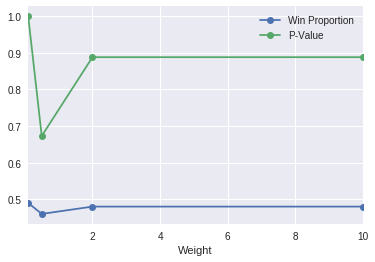

In [59]:
ws_results.plot(x='Weight', marker='o')

In [53]:
cs_weights = []
custom_score_means = []
custom_score_ps = []

for weight in custom_score_results_p1:
    cs_weights.append(weight)
    custom_score_means.append(np.mean(custom_score_results_p1[weight]))
    custom_score_ps.append(stats.ttest_ind(baseline_results_p1, custom_score_results_p1[weight])[1])
    
cs_results = pd.DataFrame()
cs_results['Weight'] = cs_weights
cs_results['Win Proportion'] = custom_score_means
cs_results['P-Value'] = custom_score_ps

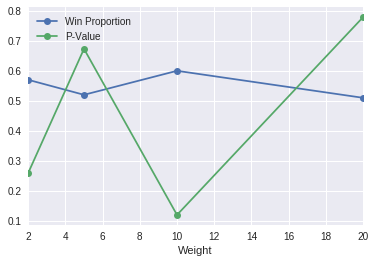

In [60]:
cs_results.plot(x='Weight', marker='o')

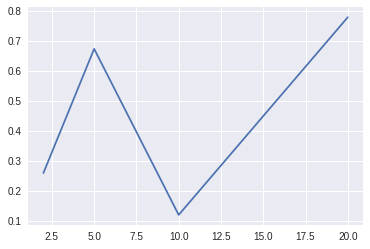

In [38]:
from scipy import stats

In [39]:
stats.ttest_ind(baseline_results_p1, custom_score_results_p1[10])

Ttest_indResult(statistic=-1.5637112573968031, pvalue=0.11948224369727156)

In [41]:
test_statistic(baseline_results_p1, custom_score_results_p1[10])

-1.5619737746804825

In [277]:
probs_r = [results[key]['probs'] for key in results]

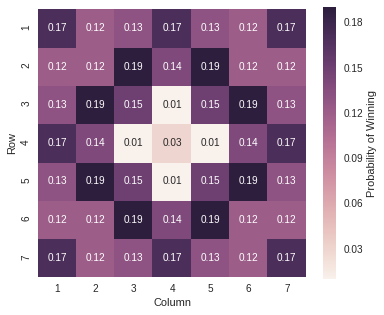

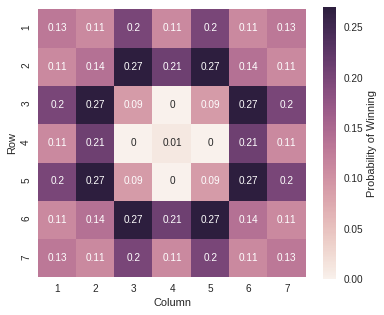

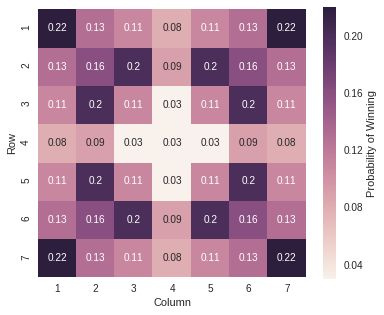

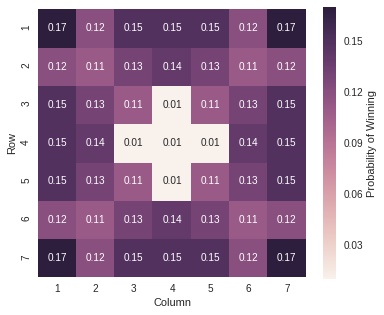

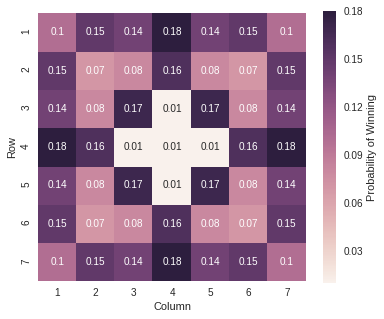

In [281]:
for i in range(len(probs_r)):
    plt.figure(figsize=(6,5))
    #plt.title("Depth of Game Based on Opening Move")
    g = sns.heatmap(probs_r[i], 
                    square=True,
                    annot=True,
                    xticklabels=range(1,w+1), 
                    yticklabels=range(1,h+1))
    g.set_xlabel('Column')
    g.set_ylabel('Row')
    cbar = g.collections[0].colorbar
    cbar.set_label('Probability of Winning')
    plt.savefig('Outcomes_IS_Against_IS_as_p1_{}.png'.format(i), dpi=240)

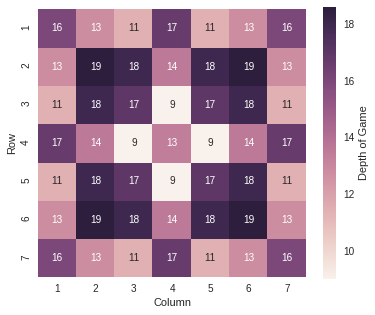

In [31]:
plt.figure(figsize=(6,5))
#plt.title("Depth of Game Based on Opening Move")
g = sns.heatmap(dpths, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1))
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
cbar.set_label('Depth of Game')
plt.savefig('Depths_IS_Against_IS_as_p1.png', dpi=240)

#### As Player 2

In [41]:
# Define game size and player types
w = 7
h = 7
CUSTOM_ARGS = {"method": 'alphabeta', 'iterative': True, 'timeout':10}
player1 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)
player2 = CustomPlayer(score_fn=improved_score, **CUSTOM_ARGS)

# Set player 1's first move
player1.first_move = (2,2)

# Define number of trials per opening move
numTrials = 10

In [42]:
probs, dpths = calcOpeningMovePerf(w, h, player1, player2, numTrials, 'player2', True)

probs.tofile('probs_against_is_as_p1.np')
dpths.tofile('dpths_against_is_as_p1.np')

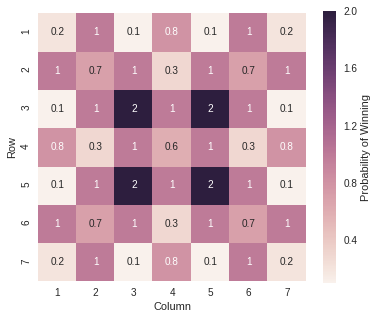

In [47]:
#probs[2,2] = 2
probs = 1 - probs


plt.figure(figsize=(6,5))
#plt.title("Depth of Game Based on Opening Move")
g = sns.heatmap(probs, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1))
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
cbar.set_label('Probability of Winning')
plt.savefig('Outcomes_IS_Against_IS_as_p2.png', dpi=240)

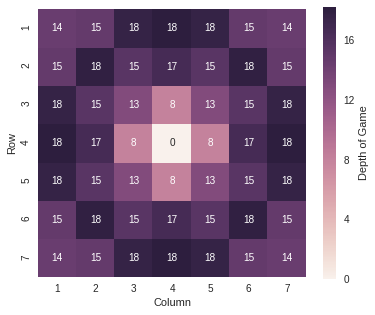

In [39]:
dpths[3,3] = 0

plt.figure(figsize=(6,5))
#plt.title("Depth of Game Based on Opening Move")
g = sns.heatmap(dpths, 
                square=True,
                annot=True,
                xticklabels=range(1,w+1), 
                yticklabels=range(1,h+1))
g.set_xlabel('Column')
g.set_ylabel('Row')
cbar = g.collections[0].colorbar
cbar.set_label('Depth of Game')
plt.savefig('Depths_IS_Against_IS_as_p2.png', dpi=240)